# Exo de Classe (Bank Exited)

## Importation des packages et Modules

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,learning_curve, GridSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
sns.set()

## 1 - Chargement du Dataset

In [2]:
df = pd.read_csv('bank.csv', sep=';',na_values='Unknown')

In [3]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
data = df.copy()

# 2 - Prétraitement du Dataset

* Suppression des Valeurs Manquante

In [5]:
data = data.drop(['CLIENTNUM'],axis=1)
data = data.dropna(axis=0)

* Encodage des variables Qualitative Nominale et Qualitative Ordinale

- Variable Qualitative Nominale

In [6]:
df_quanti = data.select_dtypes(exclude=object)
df_quali_nom = data.select_dtypes(exclude=['int64','float64']).drop(['Income_Category','Education_Level','Card_Category','Attrition_Flag'],axis=1)
df_quali_nom = pd.get_dummies(df_quali_nom,drop_first=True)
df_quali_nom

,Gender_M,Marital_Status_Married,Marital_Status_Single
0,1,1,0
1,0,0,1
2,1,1,0
4,1,1,0
5,1,1,0
...,...,...,...
10120,1,0,1
10121,0,0,1
10122,1,0,1
10124,0,1,0


- Variable Qualitative Ordinale

In [7]:
#Encodage des variable qualitative ordinale
data['Card_Category'] = data['Card_Category'].replace(['Blue','Silver','Gold','Platinum'],[0,1,2,3])

data['Income_Category'] = \
    data['Income_Category'].\
    replace(['Less than $40K','$40K - $60K','$80K - $120K','$60K - $80K','$120K +'],\
    [0,1,2,3,4])

data['Education_Level'] = \
    data['Education_Level'].\
    replace(['Graduate','High School','Uneducated','College','Post-Graduate','Doctorate'],\
    [3,2,0,1,4,5])

- Variable Cible

In [8]:
# Encodage de la variable cible
data['Attrition_Flag'] = data['Attrition_Flag'].replace(['Existing Customer','Attrited Customer'],[0,1])

- Normalisation des variable Quantitative et Traitement des Valeurs Aberrantes

* Traitement des Valeurs Aberrantes

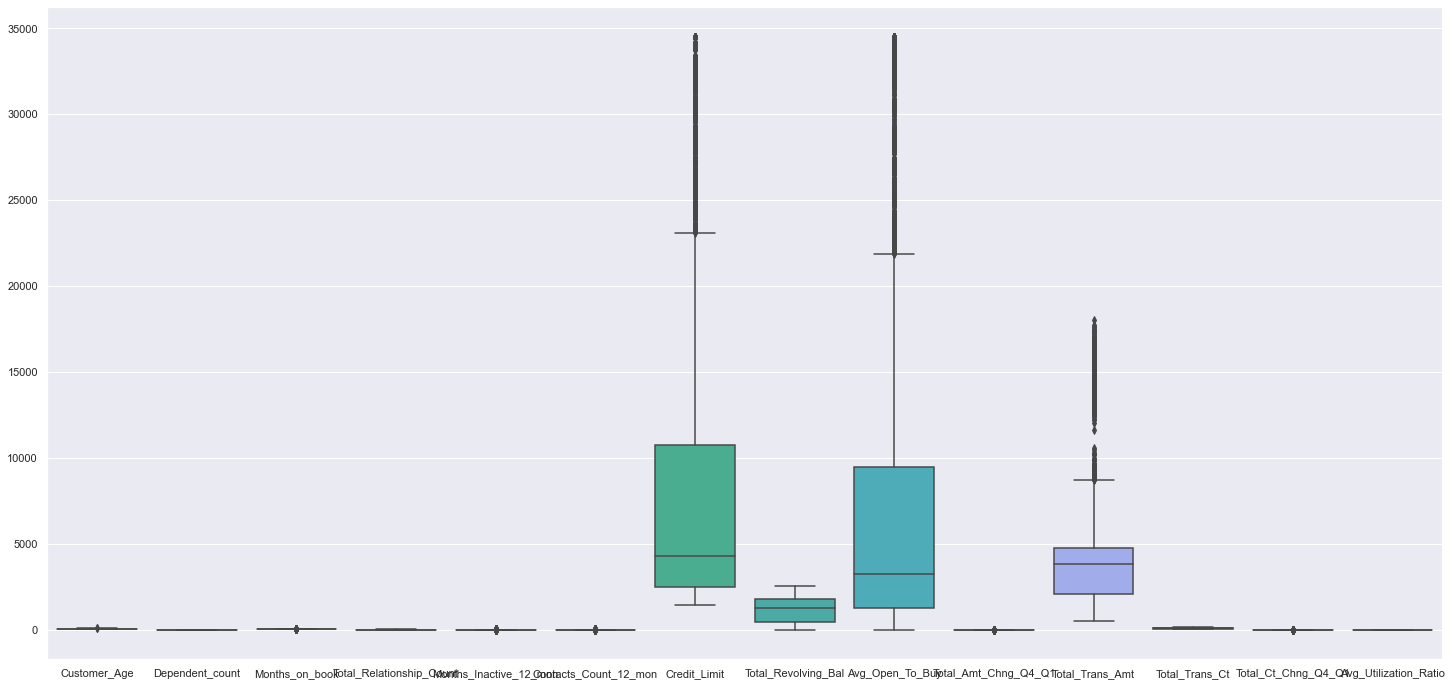

In [9]:
#Verification de l'échelle des variable
plt.figure(figsize=(25,12))
sns.boxplot(data=df_quanti)
plt.show()

In [10]:
df_quanti['Credit_Limit'],fitted_lmda = stats.boxcox(df_quanti['Credit_Limit'],lmbda=None)
df_quanti['Total_Trans_Amt'],fitted_lmda = stats.boxcox(df_quanti['Total_Trans_Amt'],lmbda=None)
df_quanti['Avg_Open_To_Buy'],fitted_lmda = stats.boxcox(df_quanti['Avg_Open_To_Buy'],lmbda=None)

In [11]:
#sns.boxplot(data=df_quanti['Credit_Limit'])

* Normalisation des Variable quatitatives

In [12]:
normaliser = StandardScaler()
df_quanti[df_quanti.columns] = normaliser.fit_transform(df_quanti)
df_quanti

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,-0.167610,0.512710,0.377234,0.764487,-1.349309,0.493777,0.990943,-0.480760,0.953855,2.574433,-1.769626,-0.945214,3.827331,-0.794057
1,0.329862,2.061228,1.002074,1.412015,-1.349309,-0.411332,0.604093,-0.373652,0.584844,3.497689,-1.556406,-1.323244,12.579779,-0.636187
2,0.578598,0.512710,0.002330,0.116959,-1.349309,-2.221550,-0.374612,-1.437353,-0.003495,8.217051,-0.911509,-1.869287,6.793694,-1.012921
4,-0.789449,0.512710,-1.872192,0.764487,-1.349309,-2.221550,0.014602,-1.437353,0.240846,6.339166,-2.386491,-1.533260,7.493388,-1.012921
5,-0.291978,-0.261549,0.002330,-0.530569,-1.349309,-0.411332,-0.176526,0.097873,-0.164044,2.758188,-1.859293,-1.701273,0.563494,0.102927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,0.951702,-1.035808,-0.247607,0.764487,-0.344317,-2.221550,1.068634,1.159112,0.948423,-0.450798,2.075651,2.079024,0.178034,-0.471142
10121,1.200438,-1.035808,1.751883,0.116959,-1.349309,1.398886,-0.279082,-0.691285,-0.081679,-0.854163,1.997023,2.331044,0.333056,-0.424499
10122,0.454230,-0.261549,0.502202,-0.530569,-0.344317,0.493777,-0.178639,0.841479,-0.351712,-0.258080,2.067822,2.205034,0.609581,0.644706
10124,-0.291978,-1.035808,0.002330,0.764487,0.660674,1.398886,0.168718,-1.437353,0.345431,0.261812,1.561194,-0.189154,0.446180,-1.012921


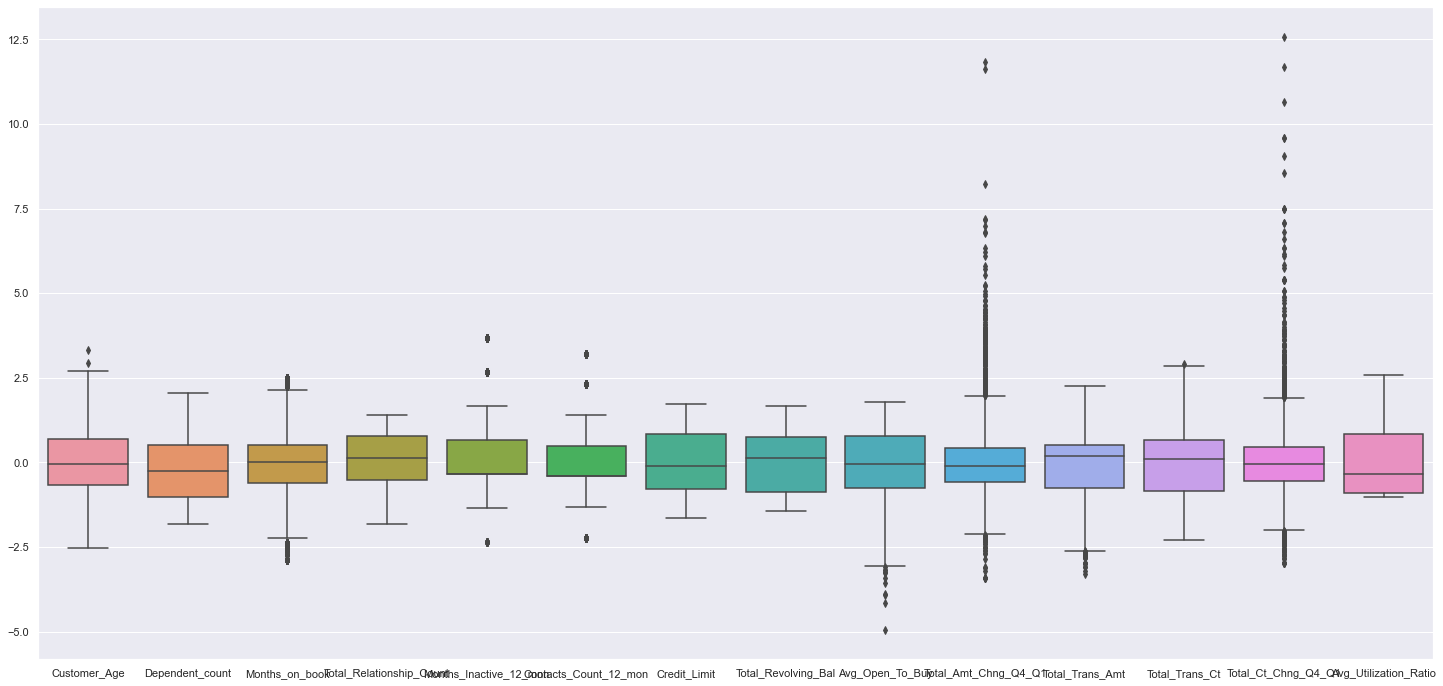

In [13]:
plt.figure(figsize=(25,12))
sns.boxplot(data=df_quanti)
plt.show()

- Assemblage du Dataset

In [14]:
datas = pd.concat([df_quali_nom,data['Card_Category'],\
                   data['Income_Category'],data['Education_Level'],\
                   df_quanti],axis=1)
datas

,Gender_M,Marital_Status_Married,Marital_Status_Single,Card_Category,Income_Category,Education_Level,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,1,0,0,3,2,-0.167610,0.512710,0.377234,0.764487,-1.349309,0.493777,0.990943,-0.480760,0.953855,2.574433,-1.769626,-0.945214,3.827331,-0.794057
1,0,0,1,0,0,3,0.329862,2.061228,1.002074,1.412015,-1.349309,-0.411332,0.604093,-0.373652,0.584844,3.497689,-1.556406,-1.323244,12.579779,-0.636187
2,1,1,0,0,2,3,0.578598,0.512710,0.002330,0.116959,-1.349309,-2.221550,-0.374612,-1.437353,-0.003495,8.217051,-0.911509,-1.869287,6.793694,-1.012921
4,1,1,0,0,3,0,-0.789449,0.512710,-1.872192,0.764487,-1.349309,-2.221550,0.014602,-1.437353,0.240846,6.339166,-2.386491,-1.533260,7.493388,-1.012921
5,1,1,0,0,1,3,-0.291978,-0.261549,0.002330,-0.530569,-1.349309,-0.411332,-0.176526,0.097873,-0.164044,2.758188,-1.859293,-1.701273,0.563494,0.102927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,1,0,1,0,3,2,0.951702,-1.035808,-0.247607,0.764487,-0.344317,-2.221550,1.068634,1.159112,0.948423,-0.450798,2.075651,2.079024,0.178034,-0.471142
10121,0,0,1,0,0,3,1.200438,-1.035808,1.751883,0.116959,-1.349309,1.398886,-0.279082,-0.691285,-0.081679,-0.854163,1.997023,2.331044,0.333056,-0.424499
10122,1,0,1,0,1,3,0.454230,-0.261549,0.502202,-0.530569,-0.344317,0.493777,-0.178639,0.841479,-0.351712,-0.258080,2.067822,2.205034,0.609581,0.644706
10124,0,1,0,0,0,2,-0.291978,-1.035808,0.002330,0.764487,0.660674,1.398886,0.168718,-1.437353,0.345431,0.261812,1.561194,-0.189154,0.446180,-1.012921


- Creation des Variables X et y

In [15]:
X = datas
y = data['Attrition_Flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=5)

# 3 - Modèlisation

- Support Vector Classifier

In [16]:
model_svc = LinearSVC(random_state=5)
model_svc.fit(X_train,y_train)

LinearSVC(random_state=5)

- Affichage des Scores du SVM

In [17]:
train_score = model_svc.score(X_train, y_train)
test_score = model_svc.score(X_test, y_test)
print('Train Score :', train_score)
print('Test Score :', test_score)

Train Score : 0.9162631154156577
Test Score : 0.9115294117647059


- Rapport de Calssification

In [18]:
y_pred = model_svc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1795
           1       0.80      0.58      0.67       330

    accuracy                           0.91      2125
   macro avg       0.86      0.78      0.81      2125
weighted avg       0.91      0.91      0.91      2125



Matrix de Confusion

In [35]:
print(pd.DataFrame(confusion_matrix(y_test,y_pred)))

      0    1
0  1746   49
1   139  191


- Courbe d'Apprentissage

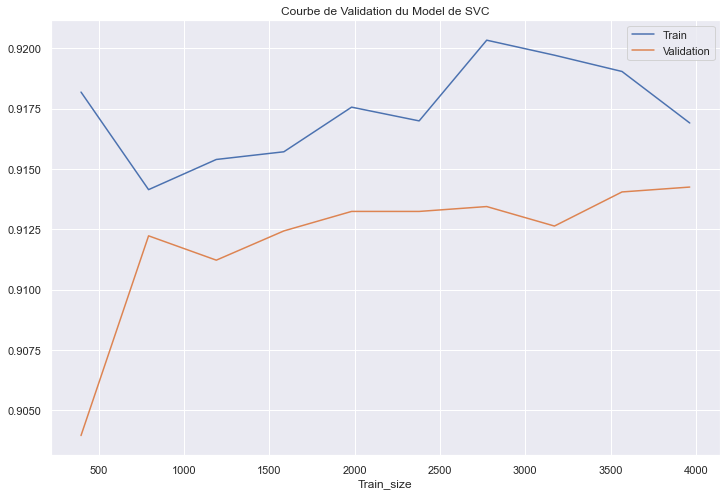

In [19]:
var, train_score, val_score = learning_curve(model_svc,X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=5)
plt.figure(figsize=(12,8))
plt.title('Courbe de Validation du Model de SVC')
plt.plot(var, train_score.mean(axis = 1), label = 'Train')
plt.plot(var, val_score.mean(axis = 1), label = 'Validation')
plt.xlabel('Train_size')
plt.legend()
plt.show()

- RandomForest

In [20]:
model_rfc = RandomForestClassifier(n_estimators=100,max_depth=5,random_state=5)
model_rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, random_state=5)

- Affichage des Scores du RandomForestClassifier

In [21]:
train_sc = model_rfc.score(X_train, y_train)
test_sc = model_rfc.score(X_test, y_test)
print('Train Score :', train_sc)
print('Test Score :', test_sc)

Train Score : 0.9277643260694108
Test Score : 0.908235294117647


- Rapport de Classification

In [22]:
y_predict = model_rfc.predict(X_test)

In [23]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1795
           1       0.87      0.48      0.62       330

    accuracy                           0.91      2125
   macro avg       0.89      0.73      0.78      2125
weighted avg       0.91      0.91      0.90      2125



In [51]:
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

      0    1
0  1771   24
1   171  159


- Courbe d'Apprentissage

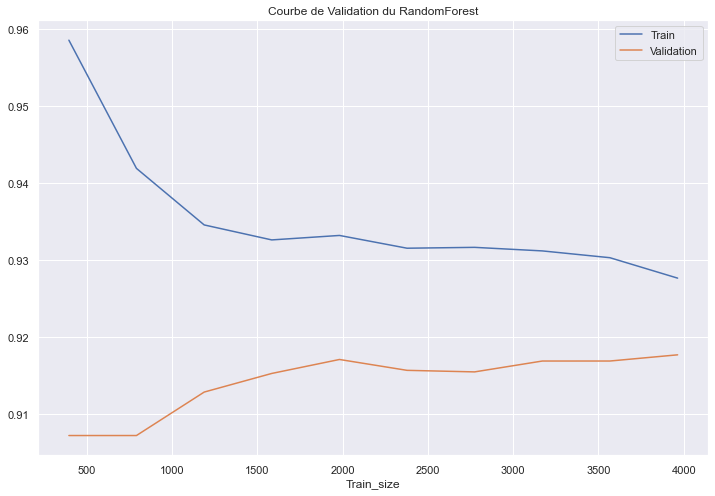

In [24]:
var, train_score, val_score = learning_curve(model_rfc,X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=5)
plt.figure(figsize=(12,8))
plt.title('Courbe de Validation du RandomForest')
plt.plot(var, train_score.mean(axis = 1), label = 'Train')
plt.plot(var, val_score.mean(axis = 1), label = 'Validation')
plt.xlabel('Train_size')
plt.legend()
plt.show()

* KNeighborsClassifier

In [25]:
model_kn = KNeighborsClassifier(n_neighbors=5)
model_kn.fit(X_train, y_train)

KNeighborsClassifier()

* Affichage du Score du Model de KNeighbors

In [26]:
train_s = model_kn.score(X_train, y_train)
test_s = model_kn.score(X_test,y_test)
print('Score d\'entrainement : ',train_s)
print('Score de test :',test_s)

Score d'entrainement :  0.935633575464084
Score de test : 0.9087058823529411


* Rapport de Classification

In [27]:
y_pre = model_kn.predict(X_test)
print(classification_report(y_test, y_pre))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1795
           1       0.85      0.50      0.63       330

    accuracy                           0.91      2125
   macro avg       0.88      0.74      0.79      2125
weighted avg       0.90      0.91      0.90      2125



In [41]:
print(pd.DataFrame(confusion_matrix(y_test,y_pre)))

      0    1
0  1767   28
1   166  164


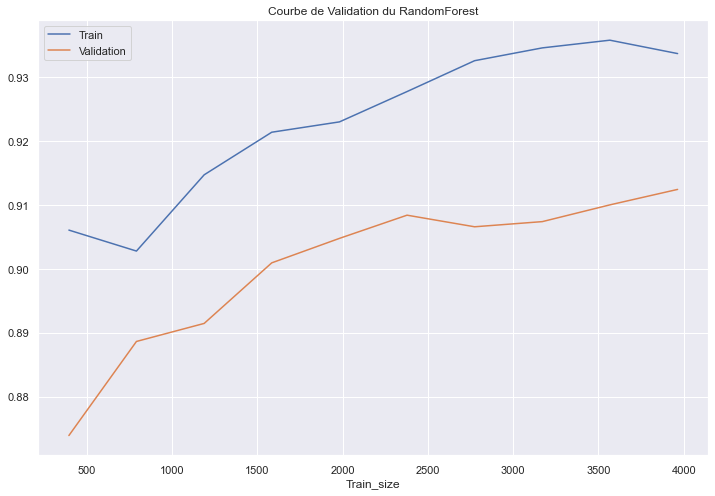

In [28]:
var, train_score, val_score = learning_curve(model_kn,X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=5)
plt.figure(figsize=(12,8))
plt.title('Courbe de Validation du RandomForest')
plt.plot(var, train_score.mean(axis = 1), label = 'Train')
plt.plot(var, val_score.mean(axis = 1), label = 'Validation')
plt.xlabel('Train_size')
plt.legend()
plt.show()

 # Optimisation des paramètres du Random Forest

In [29]:
#n_est = [int(x) for x in  np.linspace(start=100,stop=1000, num=100)]
#m_d = [int(x) for x in np.linspace(start=5,stop=50, num=5)]
#params = {'n_estimators':n_est,'criterion':['gini','entropy'],'max_depth':m_d}
#grid = GridSearchCV(RandomForestClassifier(),params,cv=5)
#grid.fit(X_train,y_train)

# Selection de Variable

In [30]:
model_rfc.feature_importances_

array([0.00712545, 0.00144223, 0.0017832 , 0.00246278, 0.00143079,
       0.00088547, 0.01350135, 0.00240436, 0.00969303, 0.06358161,
       0.0186889 , 0.02286607, 0.02026271, 0.16030893, 0.01346815,
       0.04712794, 0.17594152, 0.20248911, 0.13058963, 0.10394676])

<AxesSubplot:>

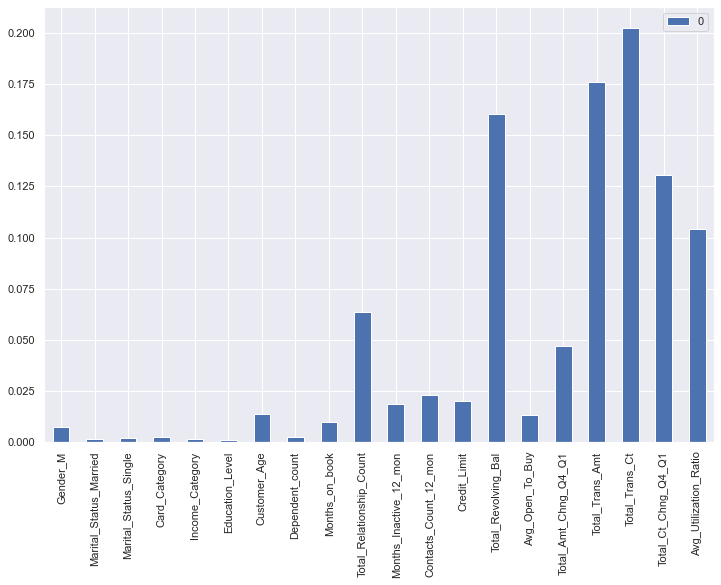

In [32]:
pd.DataFrame(model_rfc.feature_importances_,X_train.columns).plot.bar(figsize=(12,8))

- Gradient Boosting

In [44]:
g_model = GradientBoostingClassifier(n_estimators=100,learning_rate=1.0, max_depth=1,random_state=5)
g_model.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=5)

In [45]:
train_score = g_model.score(X_train, y_train)
test_score = g_model.score(X_test,y_test)
print(f'Fit:',train_score)
print(f'Train:',test_score)

Fit: 0.9711460855528652
Train: 0.9585882352941176


In [47]:
predict = g_model.predict(X_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1795
           1       0.91      0.82      0.86       330

    accuracy                           0.96      2125
   macro avg       0.94      0.90      0.92      2125
weighted avg       0.96      0.96      0.96      2125



In [48]:
print(pd.DataFrame(confusion_matrix(y_test,predict)))

      0    1
0  1767   28
1    60  270


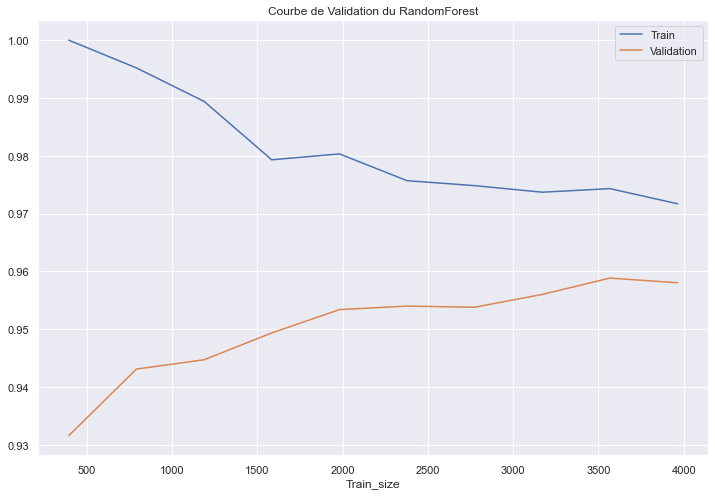

In [49]:
var, train_score, val_score = learning_curve(g_model,X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=5)
plt.figure(figsize=(12,8))
plt.title('Courbe de Validation du RandomForest')
plt.plot(var, train_score.mean(axis = 1), label = 'Train')
plt.plot(var, val_score.mean(axis = 1), label = 'Validation')
plt.xlabel('Train_size')
plt.legend()
plt.show()

<AxesSubplot:>

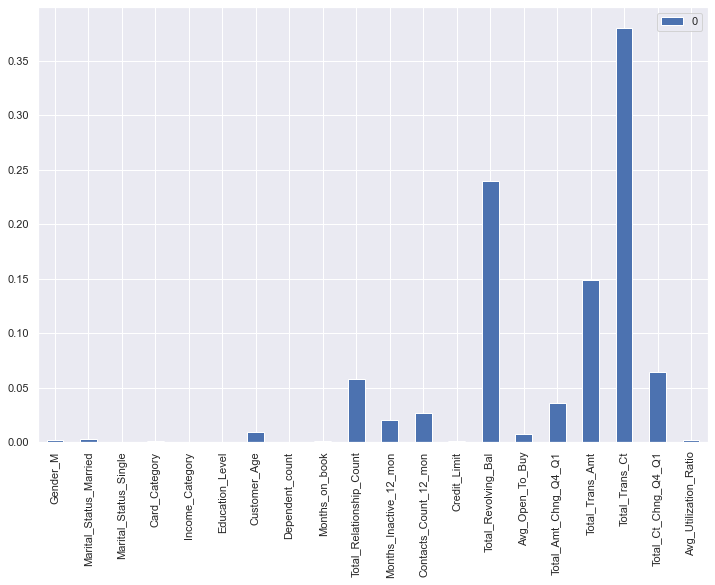

In [50]:
pd.DataFrame(g_model.feature_importances_,X_train.columns).plot.bar(figsize=(12,8))

In [ ]:
np.sort(g_model.feature_importances_)